In [45]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import json
import os

import boto3
from boto3 import session
from botocore.exceptions import ClientError

from dotenv import load_dotenv
load_dotenv()

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from urllib.request import urlopen
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import numpy as np

from time import ctime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
client = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)

In [25]:
# Prefix can also be created with datetime.strftime
snapshots = {}
providers = ['lime','bird']

month = '09'
date = '14'
hour = {'7am': '12', '2pm': '19'}

time = '2pm'
taken_at = month + "/" + date + " at " + time
print("SNAPSHOT TAKEN:", taken_at)

for org in providers:
    i = 0
    if org not in snapshots:
        snapshots[org] = []
        
    for snapshot in client.list_objects_v2(
        Bucket=os.getenv("S3_BUCKET"), 
        Prefix=org+"/2020/"+month+"/"+date+"/"+hour[time], 
        MaxKeys=1000)["Contents"]:
    # Ignore irrelevant keys
        if "samplestring" not in snapshot["Key"]:
            #print("Valid key", i)
            snapshot_obj = client.get_object(Bucket=os.getenv("S3_BUCKET"), Key=snapshot["Key"])
            snapshot_data = json.load(snapshot_obj["Body"])
            snapshots[org].append(snapshot_data)
            i+=1
    
    #print(f"Loaded {len(snapshots[org])} for {org}")

SNAPSHOT TAKEN: 09/14 at 2pm


In [26]:
def extract_time(json_obj):
    '''
    Check if a JSON object has time
    '''
    try:
        return int(json_obj['last_updated'])
    
    except KeyError:
        return 0

    
def sort_by_time(list_json):
    '''
    Sort a list of JSON objects by a certain key
    
    Inputs:
    - list_json (list): a list of JSON objects

    Returns: a sorted list
    '''
    return list_json.sort(key=extract_time)

In [27]:
for provider, data in snapshots.items():
    #print("Sorting", provider.capitalize(), "now...")
    sort_by_time(data)

In [28]:
# GLOBAL VARIABLES
zip_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/unjd-c2ca.geojson?$limit=9999999")
ca_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/igwz-8jzy.geojson?$limit=9999999")
ward_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/k9yb-bpqx.geojson")

geographies = {'zip': 
                   {'path': '../data/Boundaries - ZIP Codes.geojson', 
                    'gdf': zip_boundaries},
               'ward':
                   {'path': '../data/Boundaries - Wards (2015-).geojson',
                    'gdf': ward_boundaries},
               'community':
                   {'path': '../data/Boundaries - Community Areas (current).geojson',
                    'gdf': ca_boundaries}}

In [81]:
df_dict = {}

for org in providers:
    i = 0
    #print("Working with...", org.capitalize())
    if org not in df_dict.keys():
        df_dict[org] = {'df': None, 'color': None, 'time': None} 

    while i < len(snapshots[org]):
        if 'bikes' in snapshots[org][i]['data']:
            break
        i += 1 
        
    #print("    Looking at", i, "in list")
        
    df_dict[org]['df'] = snapshots[org][i]['data']['bikes']
    df_dict[org]['time'] = snapshots[org][i]['last_updated']
    
    if org == 'lime':
        df_dict[org]['color'] = '#b8de29'
    elif org == 'bird':
        df_dict[org]['color'] = '#2d708e'
        
# Using df_dict as a ~global~ variable from this point on

In [30]:
def build_gdf_list(df_dict):
    '''
    Builds a GeoDataFrame given a dictionary of pandas DataFrames,
    where each DataFrame contains lat/lon columns
    
    Inputs:
    - df_dict (dict): a dictionary of pandas DataFrames
    
    Returns a list of tuples of the provider and corresponding GeoDataFrame
    '''
    gdfs = []
    for provider in df_dict:
        current = df_dict[provider] # This is a dictionary

        # Initialize new keys
        current['geo_df'] = None
        current['str_time'] = None

        # Create Point objects
        df = pd.DataFrame(current['df']) # CONVERT TO A DATAFRAME

        # Make sure lat/lon are numeric
        long = pd.to_numeric(df.lon)
        lat = pd.to_numeric(df.lat)

        #print("Converting lat/lon to Point objects...")
        geometry = [Point(xy) for xy in zip(long, lat)]
        df = df.drop(['lon', 'lat'], axis=1)

        crs = {'init': 'epsg:4326'}

        # Add values to new keys
        current['geo_df'] = GeoDataFrame(df, crs=crs, geometry=geometry)
        current['str_time'] = ctime(current['time'])
        
        gdfs.append((provider, current['geo_df']))
        
    return gdfs

In [85]:
def map_static(df_dict, ax, socioecon=False):
    '''
    Converts lat/lon to Point and plots Points on a map
    
    Inputs:
    - gdfs (list): a list with pandas GeoDataFrames, color of markers, and time
    - ax (axis object): axis to plot on
    
    Outputs: an axis object
    '''
    gdfs = build_gdf_list(df_dict)
    handles = []
    
    # Format map
    ax.axis('off')
    axis_title = 'Lime: ' + df_dict['lime']['str_time'] + '        Bird: ' + df_dict['bird']['str_time']
    extra = ''
    
    # Plot base layer of community areas
    if socioecon:
        extra = 'and Median Income'
        
        palette = 'viridis'
        variable = 'MEDINC'
        vmin = ca_socioecon[variable].min()
        vmax = ca_socioecon[variable].max()
        
        ca_socioecon.plot(column=variable, cmap=palette, linewidth=0, ax=ax)
        
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=palette, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        
        cbar = fig.colorbar(sm)
        cbar.ax.set_yticklabels(['${:,.0f}'.format(i) for i in cbar.get_ticks()],
                               fontdict={'fontsize':'10', 'fontweight':'2', 'fontname': 'Lato'})
        
    else:
        ca_boundaries.plot(facecolor="lightgrey", edgecolor="white", ax=ax)
        
    # Plot scooters
    for provider, gdf in gdfs:
        if socioecon:
            gdf.plot(ax=ax, color='white', alpha=0.25, markersize=10)
            
        else:
            gdf.plot(ax=ax, color=df_dict[provider]['color'], alpha=0.5, markersize=10)
            patch = mpatches.Patch(color=df_dict[provider]['color'], label=provider.capitalize())
            handles.append(patch)
    
    # Finalize titles and legend
    plt.legend(handles=handles, loc='lower left', prop={'family': 'Lato'})
    fig_title = 'Scooter Location ' + extra + ' by Community Area'
    fig.suptitle(fig_title, fontname='Lato', fontsize=35)
    ax.set_title(axis_title, fontdict={'fontsize':'14', 'fontweight':'1', 'fontname': 'Lato'})
    
    #ax.annotate('Source: TK', 
            #xy=(0.1, .08),
            #xycoords='figure fraction', 
            #horizontalalignment='left', 
            #verticalalignment='top',
            #fontsize=12, color='#555555')
            
    if socioecon:  
        fig.savefig('../images/locations_medinc.png')
        
    else: 
        fig.savefig('../images/locations.png')


## Step 1. Plot scooter locations

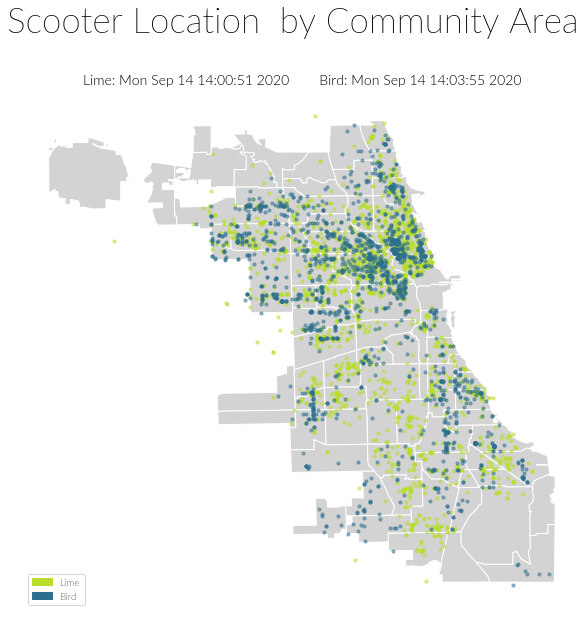

In [82]:
# Test plotting function
fig, test_ax = plt.subplots(1, figsize=(10, 10))
map_static(df_dict, test_ax)

In [64]:
def count_by_provider(df_dict):
    '''
    Creates a new GeoDataFrame with all scooters by provider
    '''
    gdfs = build_gdf_list(df_dict)
    all_scooters = pd.DataFrame()
    
    for provider, gdf in gdfs:
        #scooters = gpd.GeoDataFrame(gdf)
        print("Number of", provider.capitalize(), "scooters:", gdf.shape[0])
        gdf['provider'] = provider
        
        if provider == 'lime':
            gdf = gdf.drop('vehicle_type', axis=1)
            
        all_scooters = all_scooters.append(gdf)
        
    print("Total number of scooters:", all_scooters.shape[0])
            
    return all_scooters

In [65]:
all_scooters = count_by_provider(df_dict)

Number of Lime scooters: 2147
Number of Bird scooters: 1715
Total number of scooters: 3862


## Step 2. Check vendor compliance with equity priority area

In [66]:
equity_area = gpd.read_file("https://data.cityofchicago.org/resource/99tm-6k6i.geojson")
# equity_area.plot()

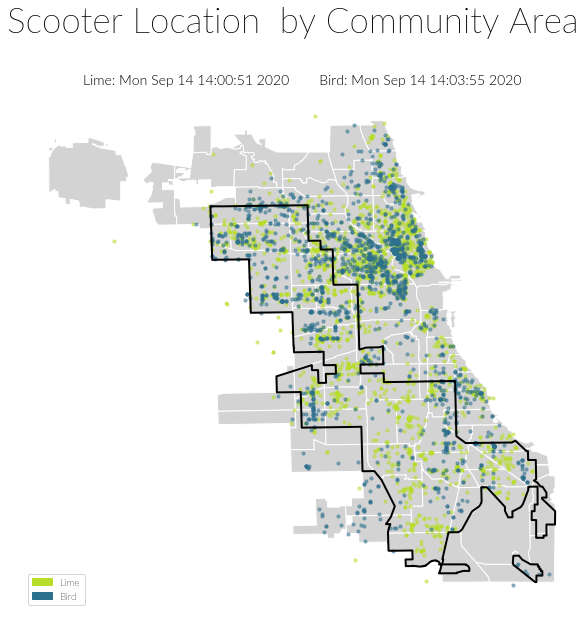

In [83]:
fig, test_ax = plt.subplots(1, figsize=(10, 10))

map_static(df_dict, test_ax)
equity_area.plot(facecolor="none", edgecolor="black", linewidth=2, ax=test_ax)

In [68]:
# Calculate how many of the scooters from each fleet are in the shapefile
def check_compliance(gdf_point, group_col, gdf_poly):
    
    total = gdf_point.groupby(group_col).size().reset_index(name='count')
    points_within = gpd.sjoin(gdf_point, gdf_poly, how="right", op='within').groupby(group_col).size().reset_index(name='count')
    
    org_compliance = {}
    
    for group in total[group_col].values:
        pct_within = (points_within.loc[points_within[group_col] == group]['count'].values[0] / total.loc[total[group_col] == group]['count'].values[0]) * 100
        print("\nIs", group.capitalize(), "complying with equity zone requirement?", pct_within >= 50)
        print("Percent of", group.capitalize(), "fleet in priority equity zone:", pct_within)
        
        org_compliance[group] = pct_within
        
    return org_compliance

In [69]:
org_compliance = check_compliance(all_scooters, 'provider', equity_area)


Is Bird complying with equity zone requirement? False
Percent of Bird fleet in priority equity zone: 42.798833819241985

Is Lime complying with equity zone requirement? False
Percent of Lime fleet in priority equity zone: 45.551932929669306


## Step 3. Overlay Census data
For reference, see [this CMAP report](https://datahub.cmap.illinois.gov/dataset/1d2dd970-f0a6-4736-96a1-3caeb431f5e4/resource/d23fc5b1-0bb5-4bcc-bf70-688201534833/download/CDSFieldDescriptions202007.pdf).

In [70]:
ca_demographics = pd.read_csv("../data/ReferenceCCAProfiles20142018.csv")
#ca_demographics.head()

In [71]:
limit_cols = ['GEOG', 'TOT_POP', 'MEDINC']
ca_limited = ca_demographics[limit_cols]

ca_limited['community'] = ca_limited['GEOG'].str.upper()
#ca_limited.head()

ca_socioecon = ca_boundaries.merge(ca_limited, on="community")

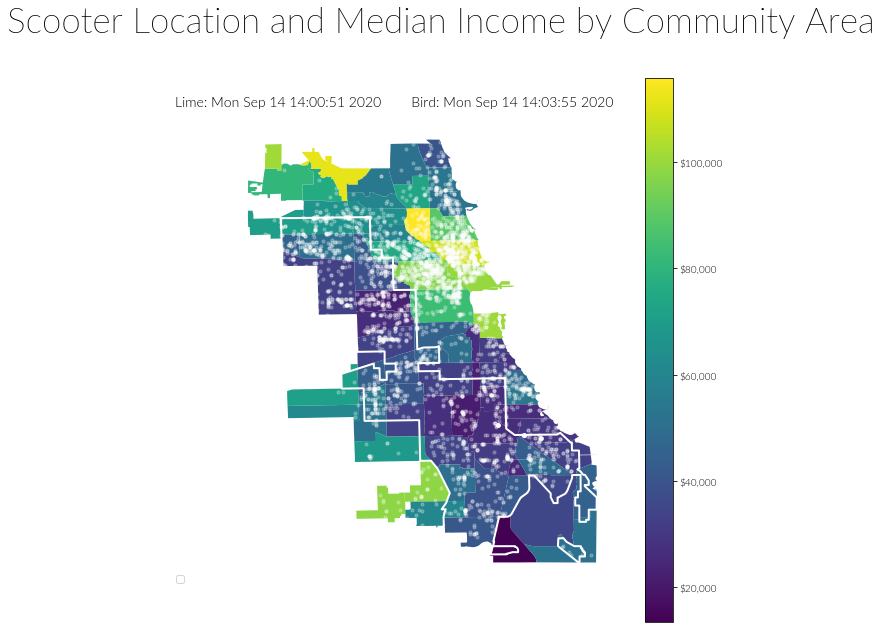

In [86]:
fig, test_ax = plt.subplots(1, figsize=(10, 10))

map_static(df_dict, test_ax, socioecon=True)
equity_area.plot(facecolor="none", edgecolor="white", linewidth=2, ax=test_ax)

### Plot scooters per population, by community area

In [73]:
ca_scooters = gpd.sjoin(all_scooters, ca_boundaries, op='within', how='left')
scooters_by_ca = ca_scooters.groupby('community').size().reset_index(name='count')
#scooters_by_ca.head()

In [74]:
ca_scooter_pop = ca_socioecon.merge(scooters_by_ca, on='community')
ca_scooter_pop['density'] = (ca_scooter_pop['count'] / ca_scooter_pop['TOT_POP']) * 1000

Text(0.1, 0.08, 'Source: Chicago Metropolitan Agency for Planning Data Hub')

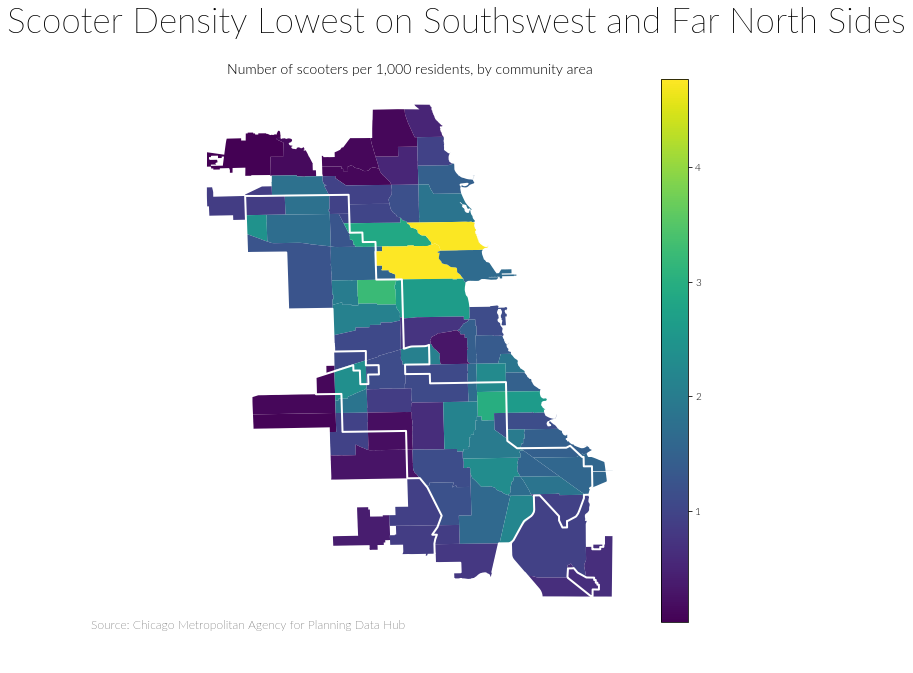

In [89]:
# Format map
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
axis_title = 'Number of scooters per 1,000 residents, by community area'
    
# Plot base layer of community areas
palette = 'viridis'
variable = 'density'
vmin = ca_scooter_pop[variable].min()
vmax = ca_scooter_pop[variable].max()
        
ca_scooter_pop.plot(column=variable, cmap=palette, linewidth=0, ax=ax)
equity_area.plot(facecolor="none", edgecolor="white", linewidth=2, ax=ax)
        
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=palette, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_yticklabels(['{:,.0f}'.format(i) for i in cbar.get_ticks()],
                         fontdict={'fontsize':'10', 'fontweight':'2', 'fontname': 'Lato'})

fig_title = 'Scooter Density Lowest on Southswest and Far North Sides'
fig.suptitle(fig_title, fontname='Lato', fontsize=35)
ax.set_title(axis_title, fontdict={'fontsize':'14', 'fontweight':'1', 'fontname': 'Lato'})
    
ax.annotate('Source: Chicago Metropolitan Agency for Planning Data Hub', 
            xy=(0.1, .08),
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top',
            fontsize=12, fontfamily='Lato', 
            color='#555555')
